# NPL  Spam Text Message Classification 

In [34]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# text preprocessing modules
from nltk.tokenize import word_tokenize

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)


import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [20]:
# load data
data = pd.read_csv("spam.tsv", sep="\t")

In [21]:
# show top five rows
data.head()

label                                            message  length  punct
0   ham  Go until jurong point, crazy.. Available only ...     111      9
1   ham                      Ok lar... Joking wif u oni...      29      6
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155      6
3   ham  U dun say so early hor... U c already then say...      49      6
4   ham  Nah I don't think he goes to usf, he lives aro...      61      2

In [22]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [23]:
# check the shape
data.shape

(5572, 4)

In [24]:
# evalute class distribution
data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

we have more normal sms than spam sms 

## Data Exploratory

In [25]:
# explore ham labeled sms
def collect_words(data, label):
    collected_words = " "

    # iterate through the csv file
    for val in data.message[data["label"] == label]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

Total words 349132


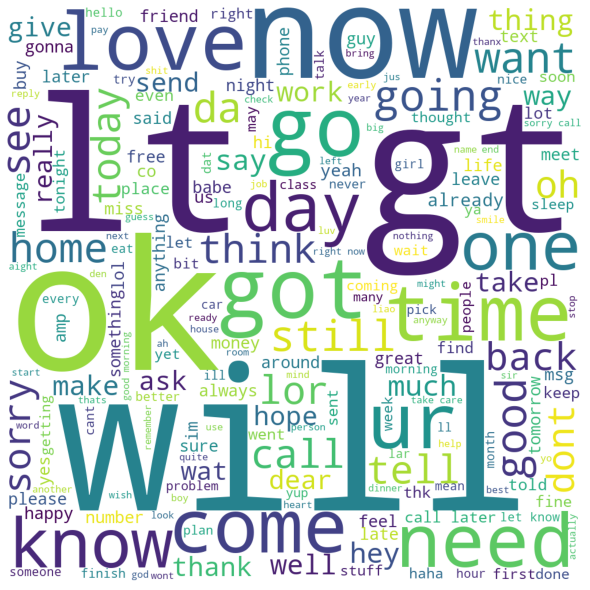

In [26]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Total words 104304


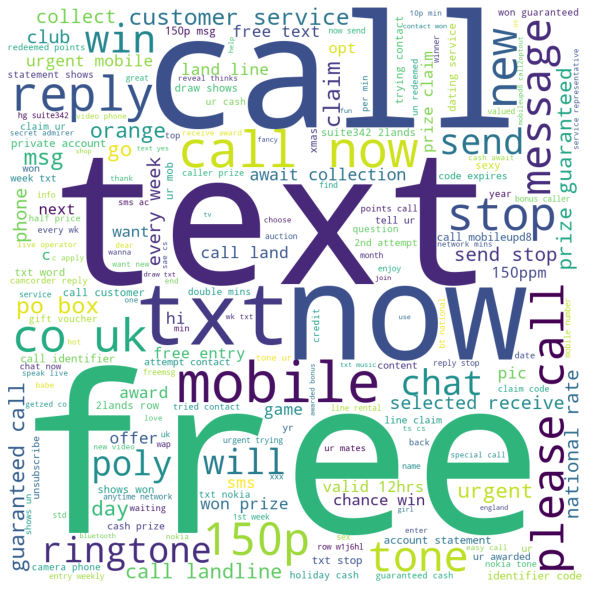

In [27]:
# visualize spam labeled sms
cloud_stopwords = set(STOPWORDS)
spam_words = collect_words(data, label="spam")

print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(spam_words)

# plot the WordCloud image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [28]:
# show spam messages
data[data["label"] == "spam"].sample(10)

label                                            message  length  punct
879   spam  U have a secret admirer who is looking 2 make ...     132      3
3860  spam  Win the newest Harry Potter and the Order of ...     138      5
3167  spam  HOT LIVE FANTASIES call now 08707509020 Just 2...     101      3
1069  spam  Someone U know has asked our dating service 2 ...     134      3
2220  spam  You have WON a guaranteed £1000 cash or a £200...     154      2
3382  spam  complimentary 4 STAR Ibiza Holiday or £10,000 ...     149      4
2850  spam  YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...     151      3
1940  spam  More people are dogging in your area now. Call...     159      6
5141  spam  FREE for 1st week! No1 Nokia tone 4 ur mobile ...     162      7
2575  spam  Your next amazing xxx PICSFREE1 video will be ...     153      2

In [29]:
# show normal messages
data[data["label"] == "ham"].sample(10)

label                                            message  length  punct
4098   ham                         i am going to bed now prin      26      0
4549   ham  Hope you are having a good week. Just checking in      49      1
168    ham  Hi frnd, which is best way to avoid missunders...      74      3
4677   ham                            Ü ready then call me...      23      3
4420   ham  How have your little darlings been so far this...     122      4
1315   ham  Got but got 2 colours lor. One colour is quite...     122      5
1348   ham                          She doesnt need any test.      25      1
3105   ham  That's y i said it's bad dat all e gals know u...      66      6
112    ham                    Going for dinner.msg you after.      31      2
4308   ham  I guess it is useless calling u 4 something im...      54      1

### Data Preparation 

In [30]:
# replace ham to 0 and spam to 1
new_data = data.replace({"ham": 0, "spam": 1})
new_data.head()

label                                            message  length  punct
0      0  Go until jurong point, crazy.. Available only ...     111      9
1      0                      Ok lar... Joking wif u oni...      29      6
2      1  Free entry in 2 a wkly comp to win FA Cup fina...     155      6
3      0  U dun say so early hor... U c already then say...      49      6
4      0  Nah I don't think he goes to usf, he lives aro...      61      2

In [47]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [48]:
#clean the dataset 
new_data["clean_message"] = new_data["message"].apply(text_cleaning)

In [49]:
new_data["clean_message"].head()

0    go j ong point crazy available bugis n great w...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final ticket 2...
3                    u dun say early hor u already say
4                  nah think go usf life around though
Name: clean_message, dtype: object

In [53]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data["clean_message"],
    new_data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

In [54]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

### Create Classifier 

In [55]:
# Create a classifier

spam_classifier = MultinomialNB()
    

In [56]:
# Train the model with cross validation
scores = cross_val_score(spam_classifier,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   24.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.3s finished


In [57]:
# find the mean of the all scores
scores.mean()

0.9767713936539371

In [61]:
# fine turning model parameters

distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [62]:
# training with randomized search
grid.fit(X_train_trans, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.4s finished


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   random_state=42, return_train_score=True, verbose=2)

In [63]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9767713936539371
MultinomialNB(alpha=1)
{'alpha': 1}


In [84]:
# Train the model with best parameters

best_classifier = MultinomialNB(alpha=1)

In [69]:
#cross validation
scores = cross_val_score(best_classifier, X_train_trans, y_train, cv=10, verbose=2, n_jobs=-1)

print(scores)
print(scores.mean())

[0.96624473 0.97468354 0.98312236 0.98101266 0.97679325 0.98945148
 0.97040169 0.97674419 0.97463002 0.97463002]
0.9767713936539371


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [85]:
# train the best_classifier 
best_classifier.fit(X_train_trans,y_train)

MultinomialNB(alpha=1)

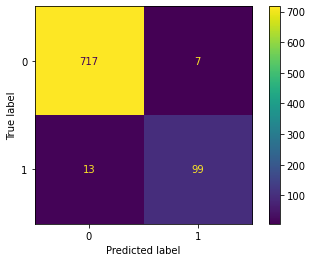

In [86]:
# plot the comfusion matrix
plot_confusion_matrix(best_classifier, X_text_trans, y_test, normalize=None)

In [87]:
# predict on the test data
y_pred = best_classifier.predict(X_text_trans)

In [88]:
# check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.93      0.88      0.91       112

    accuracy                           0.98       836
   macro avg       0.96      0.94      0.95       836
weighted avg       0.98      0.98      0.98       836



In [89]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9760765550239234

In [90]:
# check f1_ score
f1_score(y_test, y_pred)

0.908256880733945

In [91]:
#save model 
import joblib 

joblib.dump(best_classifier, '../models/spam-detection-model.pkl')

['models/spam-detection-model.pkl']

In [92]:
#save transformer 
joblib.dump(vectorizer,'../preprocessing/count_vectorizer.pkl')

['preprocessing/count_vectorizer.pkl']